## Import of libraries

In [1]:
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks
from tensorflow import argmax
from tensorflow import expand_dims
from matplotlib import pyplot as plt
from keras import utils
import matplotlib.pyplot as plt
import os 
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Treatment of the dataset

In [ ]:
#the Data Augmentation technique to improve the dataset.
gen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    rescale=1/255)

#load the train and test data by resizing it, changing its color scale and varying the batch
#and the type of dataset is specified

train_iter = gen.flow_from_directory('Covid19-dataset/train',target_size = (200, 200), 
                                       batch_size = 16,color_mode = 'rgb', class_mode='categorical')

test_iter = gen.flow_from_directory('Covid19-dataset/test',target_size = (200, 200), 
                                       batch_size = 16,color_mode = 'rgb', class_mode='categorical')

## Sample of the 3 categories of the dataset

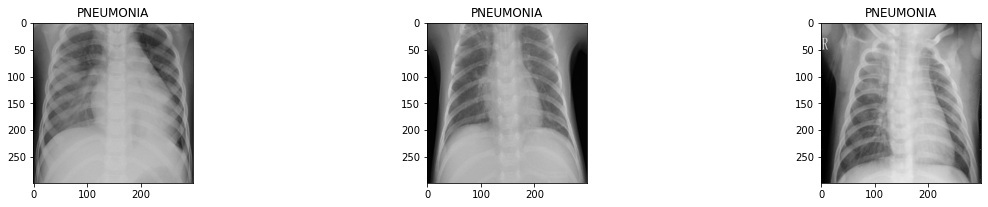

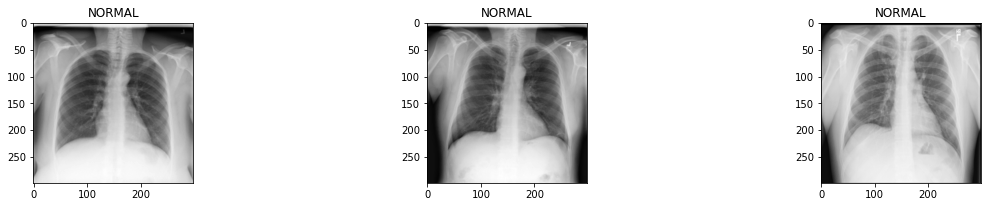

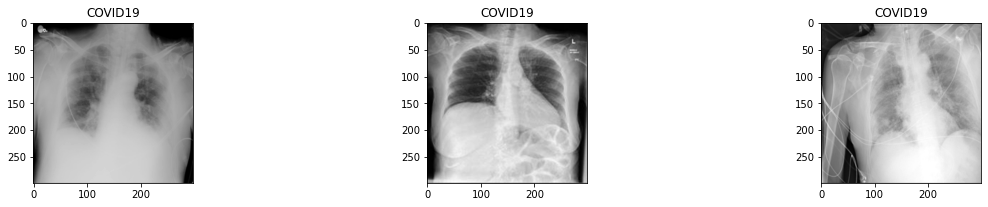

In [3]:
#Different types of images are displayed
train_image='Covid19-dataset/train'
pneumonia_images = os.listdir(train_image + "/Pneumonia")
normal_images = os.listdir(train_image + "/Normal")
covid_images = os.listdir(train_image + "/Covid")
#sPNEUMONIA tag images are displayed
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/Pneumonia",pneumonia_images[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#NORMAL label images are displayed
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/Normal",normal_images[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#COVID tag images are displayed
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/Covid",covid_images[i])),cmap='gray')
    plt.title("COVID19")

## Generation of neural networks using Transfern Learning

In [145]:
#generate the neural network, making use of transfern learning, with the VGG16
VGG16_model = VGG16(input_shape = train_iter.image_shape,
                    include_top = False, weights = 'imagenet')
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [146]:
#freeze the convolutional base layers in order to prevent their weights from being updated.
#during the training
for i in VGG16_model.layers:
    layers.trainable = False


In [149]:
#enerate the neural network, making use of transfern learning, with the Xception
xception_model = Xception(input_shape = train_iter.image_shape,
                    include_top = False, weights = 'imagenet')
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 99, 99, 32)   864         ['input_35[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 99, 99, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [150]:
#reeze the convolutional base layers in order to prevent their weights from being updated.
#during the training
for i in xception_model.layers:
    layers.trainable = False

In [151]:
#create the model with VGG16
tfVGG16_model = keras.Sequential([
    VGG16_model,   
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation='softmax'),


])
tfVGG16_model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_43 (Flatten)        (None, 18432)             0         
                                                                 
 dense_86 (Dense)            (None, 256)               4718848   
                                                                 
 dropout_67 (Dropout)        (None, 256)               0         
                                                                 
 dense_87 (Dense)            (None, 3)                 771       
                                                                 
Total params: 19,434,307
Trainable params: 19,434,307
Non-trainable params: 0
_________________________________________________________________


In [153]:
#create the model with xception
tfXception_model = keras.Sequential([
    xception_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation='softmax'),
])
tfXception_model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_45 (Flatten)        (None, 100352)            0         
                                                                 
 dense_90 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_69 (Dropout)        (None, 256)               0         
                                                                 
 dense_91 (Dense)            (None, 3)                 771       
                                                                 
Total params: 46,552,619
Trainable params: 46,498,091
Non-trainable params: 54,528
_________________________________________________________________


## Generation of the neural network created from scratch

In [154]:
#Now I create my own model
final_model = keras.Sequential([
    layers.Input(shape = train_iter.image_shape),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation='softmax'),

])
final_model.summary()


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_50 (Bat  (None, 200, 200, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_88 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                     

## Building and training the models

In [155]:
#compile the neural networks created 
tfXception_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
final_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
tfVGG16_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])



In [156]:
#The early stopping is created
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

In [157]:
#train the neural networks
history_final = final_model.fit(train_iter, epochs = 20,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test_iter)

Epoch 1/20
948/948 [==============================] - 520s 548ms/step - loss: 0.6232 - accuracy: 0.7247 - val_loss: 0.6317 - val_accuracy: 0.6927
Epoch 2/20
948/948 [==============================] - 494s 521ms/step - loss: 0.4736 - accuracy: 0.7910 - val_loss: 0.6374 - val_accuracy: 0.7033
Epoch 3/20
948/948 [==============================] - 470s 495ms/step - loss: 0.4161 - accuracy: 0.8212 - val_loss: 0.4806 - val_accuracy: 0.7960
Epoch 4/20
948/948 [==============================] - 472s 498ms/step - loss: 0.3732 - accuracy: 0.8484 - val_loss: 0.3884 - val_accuracy: 0.8493
Epoch 5/20
948/948 [==============================] - 444s 469ms/step - loss: 0.3413 - accuracy: 0.8605 - val_loss: 0.3797 - val_accuracy: 0.8413
Epoch 6/20
948/948 [==============================] - 472s 497ms/step - loss: 0.3113 - accuracy: 0.8725 - val_loss: 0.3920 - val_accuracy: 0.8347
Epoch 7/20
948/948 [==============================] - 475s 501ms/step - loss: 0.2900 - accuracy: 0.8855 - val_loss: 0.3997 -

In [158]:
history_VGG16 = tfVGG16_model.fit(train_iter, epochs = 20,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test_iter)

Epoch 1/20
948/948 [==============================] - 24395s 26s/step - loss: 0.9386 - accuracy: 0.6680 - val_loss: 1.3645 - val_accuracy: 0.3333
Epoch 2/20
948/948 [==============================] - 11248s 12s/step - loss: 0.8250 - accuracy: 0.6726 - val_loss: 1.3910 - val_accuracy: 0.3333
Epoch 3/20
948/948 [==============================] - 10259s 11s/step - loss: 0.8249 - accuracy: 0.6726 - val_loss: 1.4045 - val_accuracy: 0.3333
Epoch 4/20
948/948 [==============================] - 6021s 6s/step - loss: 0.8248 - accuracy: 0.6726 - val_loss: 1.3748 - val_accuracy: 0.3333
Epoch 5/20
948/948 [==============================] - 5245s 6s/step - loss: 0.8252 - accuracy: 0.6726 - val_loss: 1.4748 - val_accuracy: 0.3333
Epoch 6/20
948/948 [==============================] - 5765s 6s/step - loss: 0.8250 - accuracy: 0.6726 - val_loss: 1.4752 - val_accuracy: 0.3333


In [160]:
history_Xception = tfXception_model.fit(train_iter, epochs = 20,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test_iter)

Epoch 1/20
948/948 [==============================] - 3068s 3s/step - loss: 0.3943 - accuracy: 0.8703 - val_loss: 0.2498 - val_accuracy: 0.9127
Epoch 2/20
948/948 [==============================] - 3008s 3s/step - loss: 0.2221 - accuracy: 0.9257 - val_loss: 0.3647 - val_accuracy: 0.8820
Epoch 3/20
948/948 [==============================] - 2983s 3s/step - loss: 0.1553 - accuracy: 0.9498 - val_loss: 0.6913 - val_accuracy: 0.8200
Epoch 4/20
948/948 [==============================] - 3077s 3s/step - loss: 0.1656 - accuracy: 0.9465 - val_loss: 0.2663 - val_accuracy: 0.9207
Epoch 5/20
948/948 [==============================] - 3057s 3s/step - loss: 0.7117 - accuracy: 0.7908 - val_loss: 0.5907 - val_accuracy: 0.8193
Epoch 6/20
948/948 [==============================] - 3099s 3s/step - loss: 0.4239 - accuracy: 0.8428 - val_loss: 0.5629 - val_accuracy: 0.7933


NameError: name 'history_VGG16' is not defined

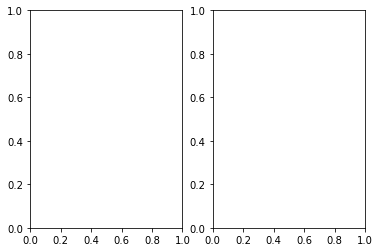

In [4]:
#a table to compare the real and expected accuracy and the real and expected loss of the model with VGG16
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_VGG16.history['accuracy'],label='training accuracy')
plt.plot(history_VGG16.history['val_accuracy'],label='training validation accurancy')
plt.title('accuracy VGG16')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.legend()
#plt.figure()
plt.sca(axarr[1]); 
plt.plot(history_VGG16.history['loss'],label='training loss' )
plt.plot(history_VGG16.history['val_loss'], label='training validation loss')
plt.title('loss VGG16')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.legend()
#plt.figure()
plt.show()

In [ ]:
#Confusion matrix for the model with VGG16
CLASS_NAMES = ["COVID-19", "NORMAL", "Viral Pneumonia"]
predictions1 = np.argmax(tfVGG16_model.predict(test_iter), axis = -1)
predictions1
cl_report1=classification_report(test_iter.classes, predictions1)
print(cl_report1)
#print(confusion_matrix(test_iter.classes,predictions1, index=CLASS_NAMES, columns=CLASS_NAMES ))
sns.heatmap(confusion_matrix(test_iter.classes,predictions1), annot = True)

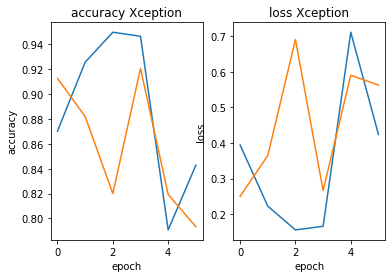

In [186]:
#a table to compare the real and expected accuracy and the real and expected loss of the model with Xception
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_Xception.history['accuracy'], label='training accuracy')
plt.plot(history_Xception.history['val_accuracy'], label='training validation accuracy')
plt.title('accuracy Xception')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.sca(axarr[1]); 
plt.plot(history_Xception.history['loss'], label='training loss')
plt.plot(history_Xception.history['val_loss'], label='training validation loss')
plt.title('loss Xception')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

94/94 [==============================] - 72s 766ms/step
              precision    recall  f1-score   support

           0       0.31      0.29      0.30       500
           1       0.32      0.31      0.32       500
           2       0.31      0.33      0.32       500

    accuracy                           0.31      1500
   macro avg       0.31      0.31      0.31      1500
weighted avg       0.31      0.31      0.31      1500

[[146 170 184]
 [155 157 188]
 [174 159 167]]


<AxesSubplot:>

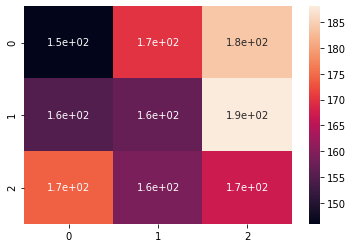

In [191]:
#Confusion matrix for the model with Xception
predictions3 = np.argmax(tfXception_model.predict(test_iter), axis = -1)
predictions3
cl_report3=classification_report(test_iter.classes,predictions3)
print(cl_report3)
print(confusion_matrix(test_iter.classes,predictions3))
sns.heatmap(confusion_matrix(test_iter.classes,predictions3), annot = True)

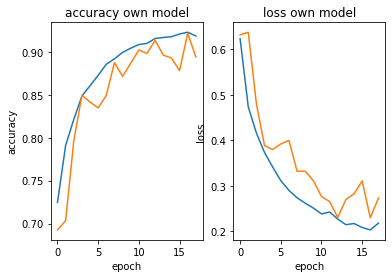

In [188]:
#a table to compare the real and expected accuracy and the real and expected loss of the model from scratch
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_final.history['accuracy'], label='training accuracy')
plt.plot(history_final.history['val_accuracy'], label='training validation accuracy')
plt.title('accuracy own model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.sca(axarr[1]); 
plt.plot(history_final.history['loss'], label='training loss')
plt.plot(history_final.history['val_loss'], label='training validation loss')
plt.title('loss own model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

94/94 [==============================] - 20s 206ms/step
              precision    recall  f1-score   support

           0       0.34      0.32      0.33       500
           1       0.32      0.38      0.35       500
           2       0.32      0.28      0.30       500

    accuracy                           0.32      1500
   macro avg       0.32      0.32      0.32      1500
weighted avg       0.32      0.32      0.32      1500

[[158 189 153]
 [160 189 151]
 [149 211 140]]


<AxesSubplot:>

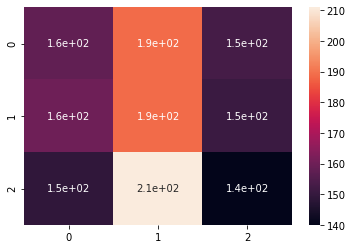

In [189]:
#Confusion matrix for the model created from scratch
predictions4 = np.argmax(final_model.predict(test_iter), axis = -1)
predictions4
cl_report4=classification_report(test_iter.classes,predictions4)
print(cl_report4)
print(confusion_matrix(test_iter.classes,predictions4))
sns.heatmap(confusion_matrix(test_iter.classes,predictions4), annot = True)

1/1 [==============================] - 0s 61ms/step
X_ray0
	Model prediction: [0.00841694 0.98663694 0.00494613]
	True label: Pneumonia (2)
	Correct: False


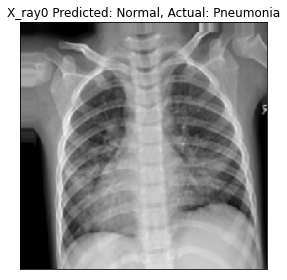

X_ray1
	Model prediction: [5.0537498e-04 9.9872488e-01 7.6971174e-04]
	True label: Normal (1)
	Correct: True


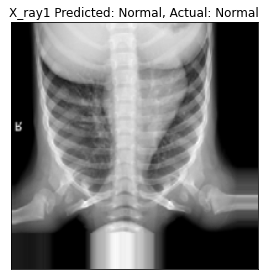

X_ray2
	Model prediction: [0.34281343 0.53860456 0.11858199]
	True label: Normal (1)
	Correct: True


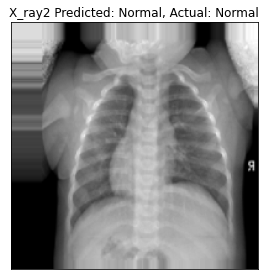

X_ray3
	Model prediction: [1.3912402e-02 9.8606110e-01 2.6516424e-05]
	True label: Normal (1)
	Correct: True


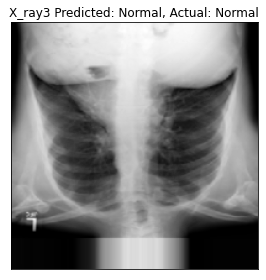

X_ray4
	Model prediction: [0.9609592  0.03627538 0.0027654 ]
	True label: Covid (0)
	Correct: True


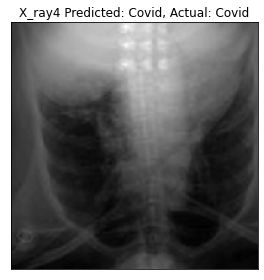

<Figure size 432x288 with 0 Axes>

In [195]:
#visualizing the operation of the model
def clean_plot(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)
#assign a value to each type of image and define a series of variables
#to test with a set of images, in this case we take only 5
class_names = {
        0: "Covid",
        1: "Normal",
        2: "Pneumonia"
    }
sample_batch_input, sample_labels = test_iter.next()
sample_batch_input = sample_batch_input[:5]
sample_labels = sample_labels[:5]

#the predictions of those 5 images and show: the image, the prediction,
#the veracity of the prediction and the real pathology of the lung
sample_predictions = final_model.predict(sample_batch_input)
for i, (image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):
    image_name = "X_ray{}".format(i)
    predicted_class = argmax(prediction).numpy()
    actual_class = argmax(label).numpy()
    print(image_name)
    print("\tModel prediction: {}".format(prediction))
    print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
    print("\tCorrect:", predicted_class == actual_class)
    sample_image = image
    clean_plot(plt.imshow(
    sample_image[:, :, 0],
    cmap = "gray"
        ))
    plt.title(image_name + " Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
    plt.tight_layout()
    plt.show()
    plt.clf()